# 1. 데이터 불러오기

## 목표 설정
---
**비즈니스 문제** : 중고차는 연식, 주행거리, 연료 타입 등 다양한 변수에 따라 가격 변동폭이 크기 때문에, 판매자와 구매자 모두 적정 시장 가격을 판단하는데 어려움을 겪는다.    

**분석 목표** : 영국 중고차 시장 내 감가 요인 분석 및 중고차 가격 예측 모델 만들기

**성공 지표** : 데이터 트랜스포밍을 통한 예측 효율성 - 데이터의 스케일을 변형하고 PCA를 통해 기존 데이터에 대한 설명력 제시

---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

car_df = pd.read_csv('cars.csv')
brand_df = pd.read_csv('brand.csv')

target_col = 'Price'

In [4]:
car_df.head()
brand_df.head()

,title,country
0,skoda,Czech Republic
1,vauxhall,United Kingdom
2,hyundai,South Korea
3,mini,United Kingdom
4,ford,United States


In [5]:
# cars.csv와 brand.csv 합치기
car_df['brand_name'] = car_df['title'].str.split().str[0].str.lower()
brand_df['title'] = brand_df['title'].str.strip().str.lower()

merged_df = pd.merge(car_df, brand_df, left_on='brand_name', right_on='title', how='left')

merged_df = merged_df.drop(columns=['title_y']).rename(columns={'title_x': 'title'})

print("병합 후 데이터 컬럼 :", merged_df.columns)

merged_df[['title', 'brand_name', 'country']].head()

병합 후 데이터 컬럼 : Index(['title', 'Price', 'Mileage(miles)', 'Registration_Year',
       'Previous Owners', 'Fuel type', 'Body type', 'Engine', 'Gearbox',
       'Doors', 'Seats', 'Emission Class', 'Service history', 'brand_name',
       'country'],
      dtype='object')


,title,brand_name,country
0,SKODA FABIA,skoda,Czech Republic
1,VAUXHALL CORSA,vauxhall,United Kingdom
2,HYUNDAI I30,hyundai,South Korea
3,MINI HATCH,mini,United Kingdom
4,VAUXHALL CORSA,vauxhall,United Kingdom


# 2. 데이터 전처리

## 결측치 처리

In [6]:
# 합친 데이터 결측치 확인
print(merged_df.isnull().sum())

title                   0
Price                   0
Mileage(miles)          0
Registration_Year       0
Previous Owners      1411
Fuel type               0
Body type               0
Engine                 45
Gearbox                 0
Doors                  25
Seats                  35
Emission Class         87
Service history      3147
brand_name              0
country                 0
dtype: int64


In [7]:
# Service history는 Unknown으로 채우기
merged_df['Service history'] = merged_df['Service history'].fillna('Unknown')

In [11]:
# 결측치 변수가 일정 개수 이상 포함된 데이터는 제거
df = merged_df[merged_df.isnull().sum(axis=1) < 3].copy()

In [12]:
# 카테고리 -> 수치 변환 (Engine 컬럼에서 숫자만 추출하여 새로운 Engine_Size 생성)
df['Engine_Size'] = df['Engine'].str.replace('L', '', regex=False).astype(float)    # 단위 L를 지우고 숫자만 남김
df['Engine_Size'] = df['Engine_Size'].fillna(df['Engine_Size'].median())

In [13]:
# 수치형 -> 중앙값으로 채우기
df['Previous Owners'] = df['Previous Owners'].fillna(df['Previous Owners'].median())

df['Doors'] = df['Doors'].fillna(df['Doors'].median())
df['Seats'] = df['Seats'].fillna(df['Seats'].median())

In [14]:
# 문자열 -> 최빈값으로 채우기
emission_mode = df['Emission Class'].mode()[0]
df['Emission Class'] = df['Emission Class'].fillna(emission_mode)

df['Engine'] = df['Engine'].fillna(df['Engine'].mode()[0])

In [15]:
# 확인 코드
print(f"필터링 전 데이터 개수: {len(merged_df)}")
print(f"\n필터링 후(최종) 데이터 개수: {len(df)}")
print(df.isnull().sum())

필터링 전 데이터 개수: 3687

필터링 후(최종) 데이터 개수: 3626
title                0
Price                0
Mileage(miles)       0
Registration_Year    0
Previous Owners      0
Fuel type            0
Body type            0
Engine               0
Gearbox              0
Doors                0
Seats                0
Emission Class       0
Service history      0
brand_name           0
country              0
Engine_Size          0
dtype: int64


## 이상치 탐지 및 처리

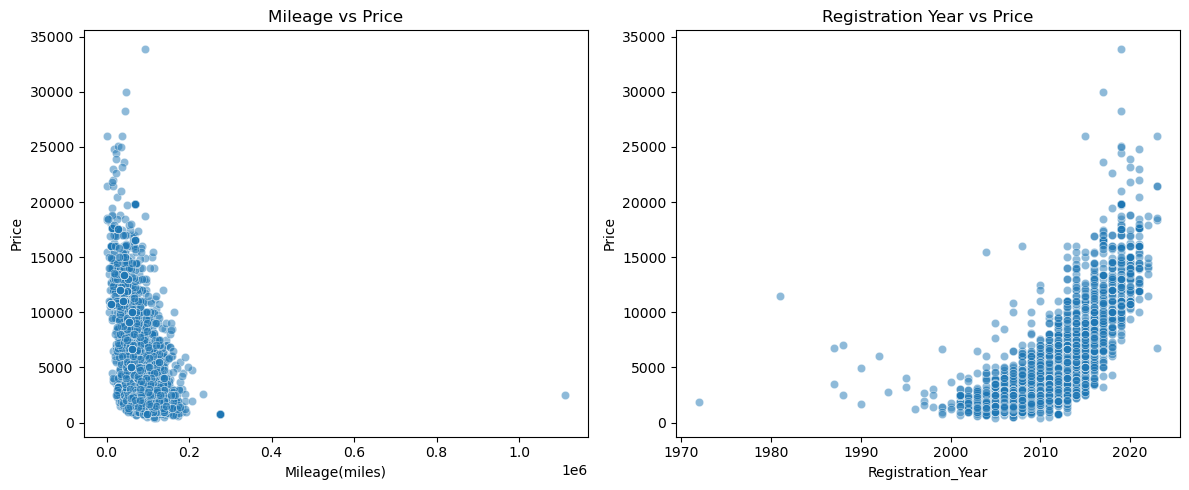

In [16]:
# 스캐터 플롯으로 이상치 확인하기
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='Mileage(miles)', y='Price', alpha=0.5)
plt.title('Mileage vs Price')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Registration_Year', y='Price', alpha=0.5)
plt.title('Registration Year vs Price')

plt.tight_layout()
plt.show()

- `Mileage`에서 오른쪽으로 튀어나온 점 : 과도한 주행거리
- `Price`에서 너무 위로 솟은 점 : 비정상적인 고가 차량
- `Registration`에서 너무 왼쪽에 있는 점 : 오래된 차량

In [17]:
outlier_cols = ['Price', 'Mileage(miles)']

for col in outlier_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    before_count = len(df)
    df = df[(df[col] >= lower_limit) & (df[col] <= upper_limit)]
    after_count = len(df)
    
    print(f"{col} 처리 결과: {before_count - after_count}개의 이상치 제거됨")

print(f"\n최종 남은 데이터 개수: {len(df)}")

Price 처리 결과: 124개의 이상치 제거됨
Mileage(miles) 처리 결과: 26개의 이상치 제거됨

최종 남은 데이터 개수: 3476


## 데이터 타입 변환

In [18]:
# 피처 엔지니어링 - 순서형 변수
df['Emission_Label'] = df['Emission Class'].str.extract('(\d+)').astype(int)    # 숫자(\d+)만 뽑아냄

In [19]:
# 피처 엔지니어링 - 명목형 변수
# One - Hot Encoding
encoding_cols = ['Fuel type', 'Body type', 'Gearbox', 'country', 'Service history']
df_encoded = pd.get_dummies(df, columns=encoding_cols, drop_first=True)

In [20]:
# 불필요한 컬럼 제거
final_df = df_encoded.drop(columns=['title', 'Engine', 'Emission Class', 'brand_name'])

print(final_df.head())

   Price  Mileage(miles)  Registration_Year  Previous Owners  Doors  Seats  \
0   6900           70189               2016              3.0    5.0    5.0   
1   1495           88585               2008              4.0    3.0    5.0   
2    949          137000               2011              3.0    5.0    5.0   
3   2395           96731               2010              5.0    3.0    4.0   
4   1000           85000               2013              3.0    5.0    5.0   

   Engine_Size  Emission_Label  Fuel type_Petrol  Fuel type_Petrol Hybrid  \
0          1.4               6             False                    False   
1          1.2               4              True                    False   
2          1.4               5              True                    False   
3          1.4               4              True                    False   
4          1.3               5             False                    False   

   ...  country_Italy  country_Japan  country_Malaysia  country_Roma

In [21]:
# 데이터 스케일링 - StandardScaler
from sklearn.preprocessing import StandardScaler

X = final_df.drop(columns=['Price'])
y = final_df['Price']

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("--- 스케일링 완료 ---")
print(X_scaled_df.head())

print("\n--- 변환 후 평균/표준편차 확인 ---")
print(X_scaled_df[['Mileage(miles)', 'Registration_Year', 'Engine_Size']].head())



--- 스케일링 완료 ---
   Mileage(miles)  Registration_Year  Previous Owners     Doors     Seats  \
0       -0.349085           0.907038         0.068903  0.684380  0.163730   
1        0.205535          -0.756413         0.897652 -1.363752  0.163730   
2        1.665197          -0.132619         0.068903  0.684380  0.163730   
3        0.451128          -0.340550         1.726401 -1.363752 -1.560892   
4        0.097451           0.283244         0.068903  0.684380  0.163730   

   Engine_Size  Emission_Label  Fuel type_Petrol  Fuel type_Petrol Hybrid  \
0    -0.407614        1.250782         -1.373697                -0.111917   
1    -0.821418       -0.979389          0.727963                -0.111917   
2    -0.407614        0.135697          0.727963                -0.111917   
3    -0.407614       -0.979389          0.727963                -0.111917   
4    -0.614516        0.135697         -1.373697                -0.111917   

   Fuel type_Petrol Plug-in Hybrid  ...  country_Italy  co

### StandardScaler를 사용한 이유
- 차원 축소는 분산을 기준으로 하는데, 스케일링을 진행하지 않으면 단순히 숫자가 큰 변수가 분산의 대부분을 차지하게 되기 때문에 PCA 전에는 스케일링을 거쳐야한다.
- StandardScaler를 통해 서로 다른 단위를 가지고 있는 변수들의 평균을 0, 표준편차를 1로 맞춰서 모든 데이터가 동일 선상에서 비교되도록 만들어주었다.
- 이상치를 처리했기 때문에 RobustScaler를 사용할 필요가 없다.
- 정규분포 모양이 나올것으로 예상되는 중고차 가격 예측 모델에는 StandardScaler가 안정적이다. MinMaxScaler는 0~1 사이로 압축할 뿐이기 때문에 분포의 모양을 조절하지 못한다.

## PCA

In [22]:
# 기존 데이터의 70% 이상을 가지는 수준에서 최소한의 주성분 추출
from sklearn.decomposition import PCA

pca = PCA(n_components=0.70)
X_pca = pca.fit_transform(X_scaled)

In [23]:
n_cols = X_pca.shape[1]
print(f"추출된 주성분 개수: {n_cols}개")

추출된 주성분 개수: 16개


In [24]:
pca_cols = [f'PC{i+1}' for i in range(n_cols)]
X_pca_df = pd.DataFrame(X_pca, columns=pca_cols)

print(X_pca_df.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.430342  0.790746  0.348275 -0.601703  0.329796 -0.405727 -0.399907   
1 -0.280983 -1.903250 -0.803904 -0.340788  0.000967  1.736560  1.153792   
2 -0.666370 -0.202785 -1.072420  0.368316 -0.526273  0.847692 -2.182220   
3  0.017733 -2.521820 -0.281966 -0.248466 -0.174670  1.683554  0.779460   
4 -1.017753  0.120313 -0.421319 -0.837772  0.254620  1.048243  0.507906   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.422573 -0.155897  0.063561 -0.740900 -0.111120  0.025387  0.031062   
1  0.020897  0.890058  0.098626  0.654519  0.433106  0.443284 -0.060380   
2 -0.029340 -1.513001 -0.026492 -0.198321  0.729955  0.169718 -0.612529   
3 -0.300600  0.844591  0.296486  0.375505  0.188802  0.518395 -0.022204   
4 -1.295836  0.344123  0.094875 -0.904953 -0.272968  0.168040 -0.084298   

       PC15      PC16  
0 -0.057675  0.079006  
1  0.204815 -0.682440  
2  0.856493  0.775461  
3 

# 3. EDA

## 단변량 분석

--- 국가별 브랜드 개수 ---
           Country  Brand_Count
0            Japan           11
1   United Kingdom            8
2          Germany            6
3    United States            5
4           France            4
5            Italy            4
6      South Korea            4
7           Sweden            2
8   Czech Republic            1
9         Malaysia            1
10         Romania            1
11           Spain            1


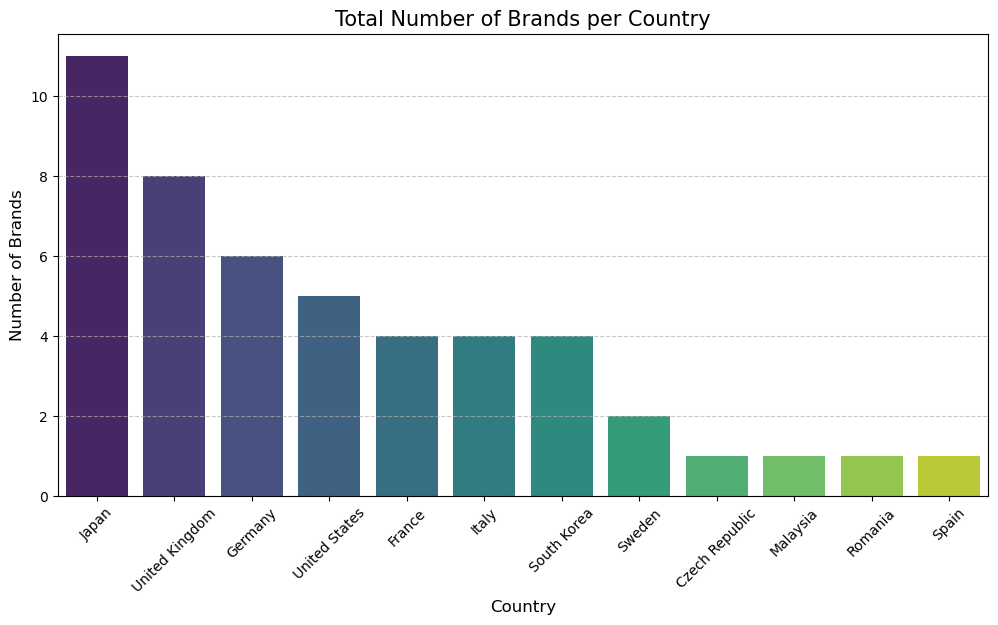

In [25]:
# 국가별 총 브랜드 개수
brand_counts = brand_df.groupby('country')['title'].count().sort_values(ascending=False).reset_index()
brand_counts.columns = ['Country', 'Brand_Count']

print("--- 국가별 브랜드 개수 ---")
print(brand_counts)

plt.figure(figsize=(12, 6))
sns.barplot(data=brand_counts, x='Country', y='Brand_Count', hue='Country', palette='viridis', legend=False)

plt.title('Total Number of Brands per Country', fontsize=15)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Brands', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

- 일본, 영국, 독일 브랜드가 큰 비중을 차지하고 있다.
- 브랜드 개수가 적은 국가의 차량 데이터는 모델 학습할 때 샘플이 부족할 수 있으므로 제거 후 학습할지 말지 고민해보아야 한다.

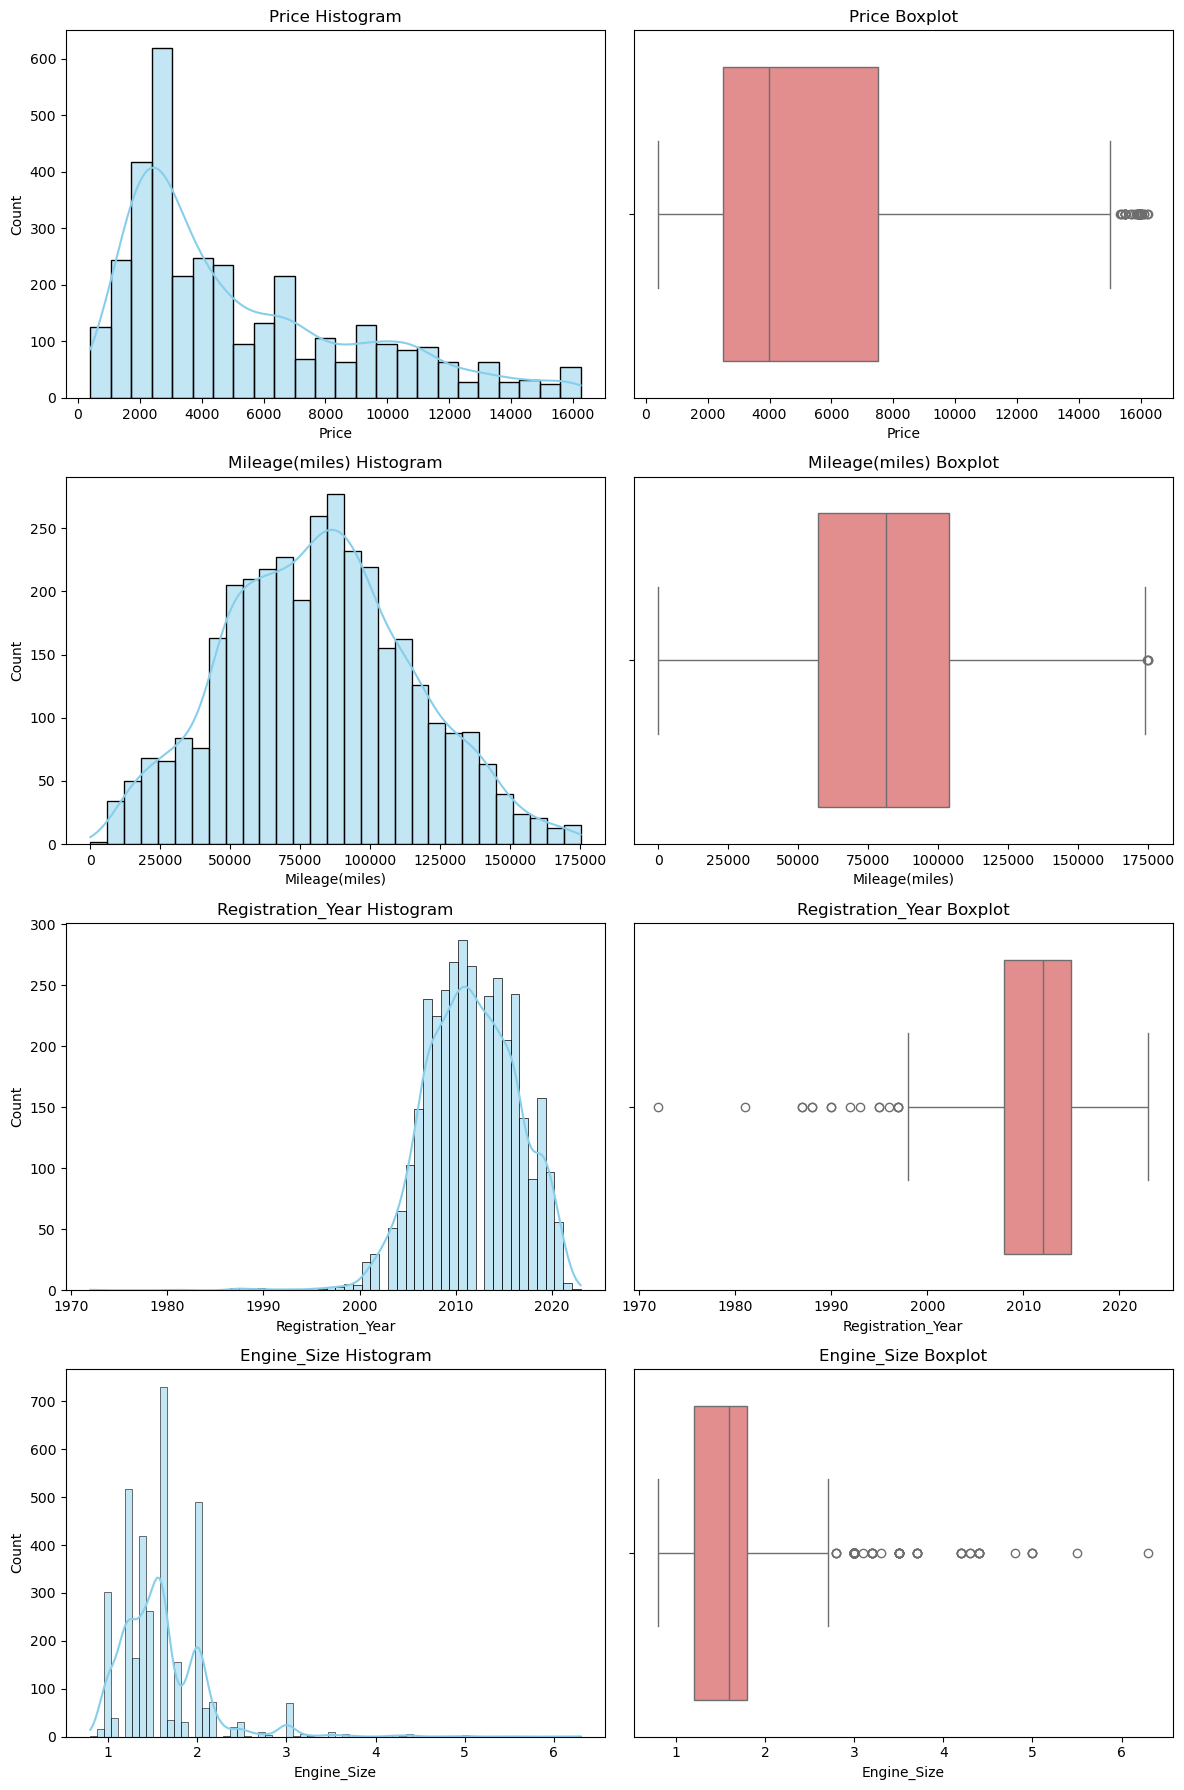

In [26]:
# 수치형 변수 분포 확인
num_cols = ['Price', 'Mileage(miles)', 'Registration_Year', 'Engine_Size']

plt.figure(figsize=(12, 18))

for i, col in enumerate(num_cols):
    plt.subplot(4, 2, i*2 + 1)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'{col} Histogram')
    
    plt.subplot(4, 2, i*2 + 2)
    sns.boxplot(x=df[col], color='lightcoral') 
    plt.title(f'{col} Boxplot')

plt.tight_layout()
plt.show()

In [27]:
# 기술통계량
print("--- 수치형 변수 기술통계량 ---")
print(df[num_cols].describe())

--- 수치형 변수 기술통계량 ---
              Price  Mileage(miles)  Registration_Year  Engine_Size
count   3476.000000     3476.000000        3476.000000  3476.000000
mean    5339.939298    81767.686997        2011.637802     1.597008
std     3778.953272    33173.400745           4.809971     0.483390
min      400.000000        6.000000        1972.000000     0.800000
25%     2490.000000    57209.500000        2008.000000     1.200000
50%     3995.000000    81223.000000        2012.000000     1.600000
75%     7500.000000   104000.000000        2015.000000     1.800000
max    16250.000000   175112.000000        2023.000000     6.300000


- `Price`나 `Mileage`가 오른쪽으로 긴 꼬리를 가진 형태를 하고 있다. 대부분의 차량은 저렴하고 주행거리가 짧지만 일부 고가의 특수매물이나 장거리 주행 차량이 평균값을 끌어올리고 있다고 볼 수 있다.
  - `Price`처럼 평균과 중앙값 차이가 크다면 대표값으로 평균 대신 중앙값을 사용하는 것이 더 정확하다.
- `Registration_Year`의 표준편차가 4.6으로 작은 결과가 나왔는데, 이는 매물들이 특정 연식에 집중되어있는 것으로 볼 수있다.
- 이상치를 제거했음에도 불구하고 박스 플롯에서 보이는 외부 점들은 이상치가 아니라 현실에 존재하는 극단적인 케이스일 수 있다.

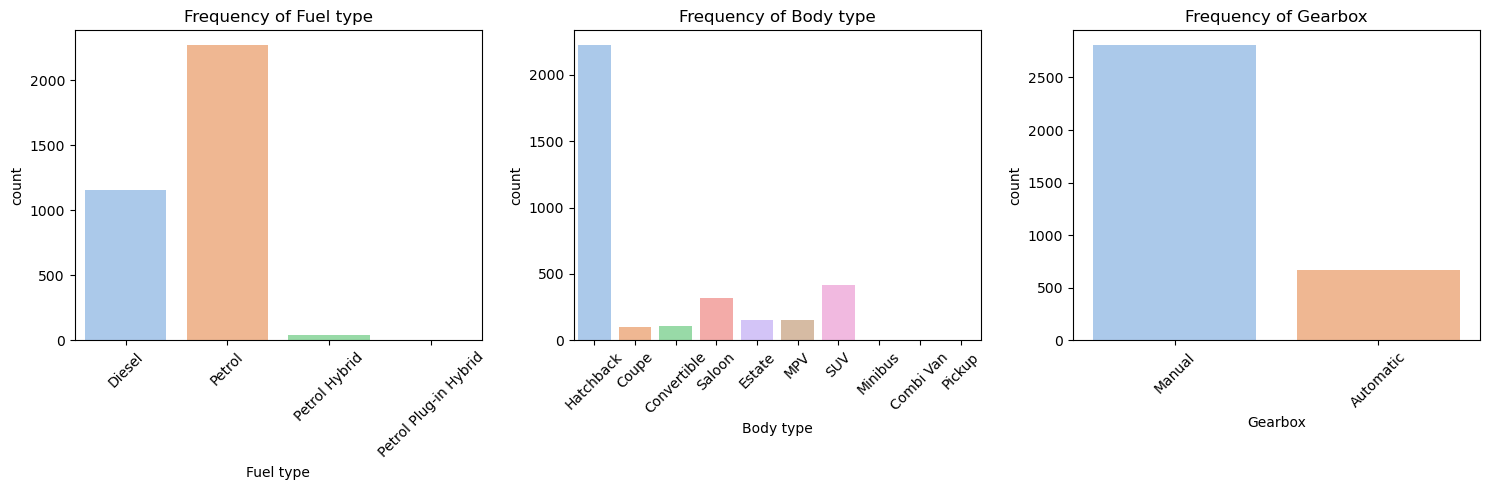


--- Fuel type 빈도표 ---
Fuel type
Petrol                   2272
Diesel                   1157
Petrol Hybrid              43
Petrol Plug-in Hybrid       4
Name: count, dtype: int64

--- Body type 빈도표 ---
Body type
Hatchback      2223
SUV             414
Saloon          321
Estate          153
MPV             150
Convertible     109
Coupe           101
Combi Van         2
Pickup            2
Minibus           1
Name: count, dtype: int64

--- Gearbox 빈도표 ---
Gearbox
Manual       2808
Automatic     668
Name: count, dtype: int64


In [28]:
# 범주형 변수 분포 확인
cat_cols = ['Fuel type', 'Body type', 'Gearbox']

plt.figure(figsize=(15, 5))
for i, col in enumerate(cat_cols):
    plt.subplot(1, 3, i + 1)
    sns.countplot(data=df, x=col, hue=col, palette='pastel', legend=False)
    plt.title(f'Frequency of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

for col in cat_cols:
    print(f"\n--- {col} 빈도표 ---")
    print(df[col].value_counts())

- `Body type`에서 Petrol이 가장 큰 비중을 차지하고 있다. 이는 이 데이터셋이 가솔린 차량의 가격을 예측하는데 최적화 되어있는 것으로 볼 수 있다.
- `Body type`에서 Pickup이나 Minibus의 빈도가 낮게 나오는데, 모델이 해당 차종의 특성을 충분히 학습하지 못해 예측력이 떨어질 수 있다.
- `Gearbox`에서 Manual 비율이 높은 것은 해당 지역의 특성을 반영한 것이라고 볼 수 있다.

## 이변량 분석

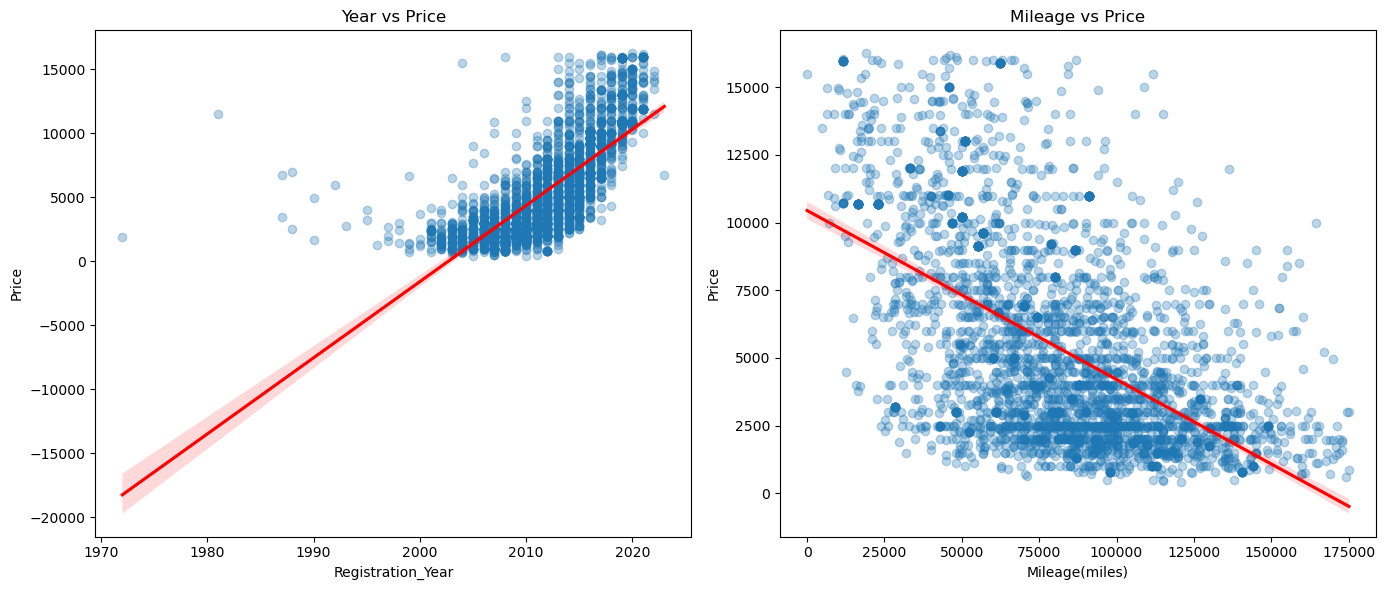

In [29]:
# 연식 vs 가격
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.regplot(data=df, x='Registration_Year', y='Price', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Year vs Price')

# 주행거리 vs 가격
plt.subplot(1, 2, 2)
sns.regplot(data=df, x='Mileage(miles)', y='Price', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Mileage vs Price')

plt.tight_layout()
plt.show()

- 연식은 양의 상관관계, 주행거리는 음의 상관관계를 가지고 있는 것을 관찰할 수 있다.

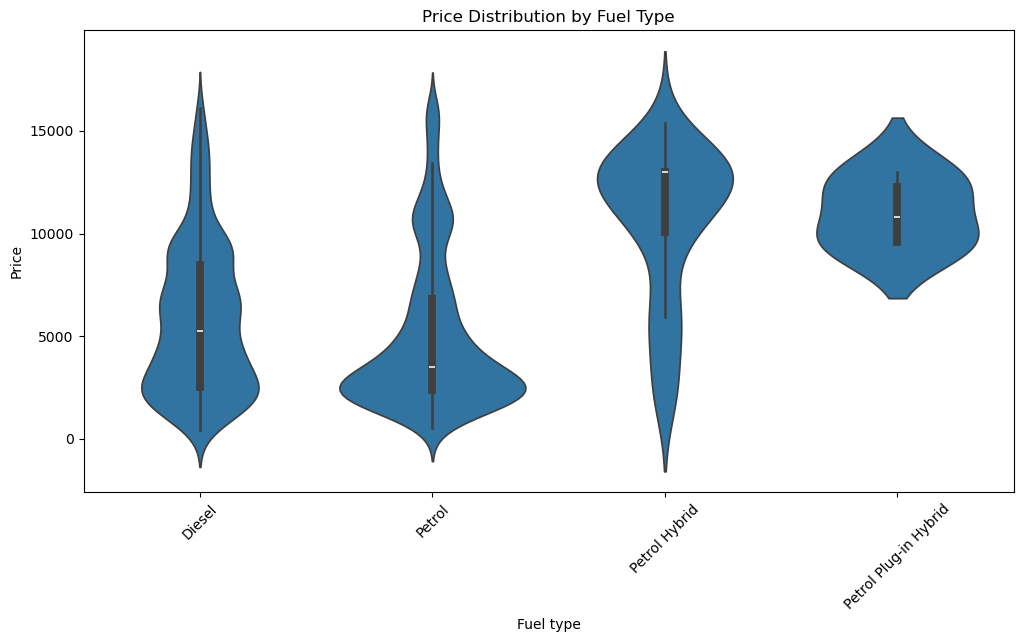

In [30]:
# 연료 타입별 가격 분포
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='Fuel type', y='Price')
plt.title('Price Distribution by Fuel Type')
plt.xticks(rotation=45)
plt.show()

In [31]:
# ANOVA 검정
from scipy import stats

groups = [df[df['Fuel type'] == f]['Price'] for f in df['Fuel type'].unique()]
f_stat, p_val = stats.f_oneway(*groups)

print(f"--- Fuel type에 따른 가격 차이 검정 ---")
print(f"F-통계량: {f_stat:.4f}")
print(f"p-value: {p_val:.4f}")

if p_val < 0.05:
    print("결과: p-value가 0.05 미만이므로, 연료 타입에 따른 가격 차이는 유의미하다.")
else:
    print("결과: 연료 타입에 따른 가격 차이가 통계적으로 유의미하지 않다.")

--- Fuel type에 따른 가격 차이 검정 ---
F-통계량: 44.1629
p-value: 0.0000
결과: p-value가 0.05 미만이므로, 연료 타입에 따른 가격 차이는 유의미하다.


- 바이올린 플롯에서 배가 위치한 높이가 그룹마다 다른 것을 확인할 수 있다. 이는 특정 연료(Hybrid)가 다른 연료(Petrol)보다 비싸게 거래됨을 알 수 있다. 
- ANOVA 검정에서 p-value < 0.05가 나왔으므로, "연료 타입은 가격을 결정하는 중요한 변수이다"라는 가설을 채택할 수 있다.

## 다변량 분석

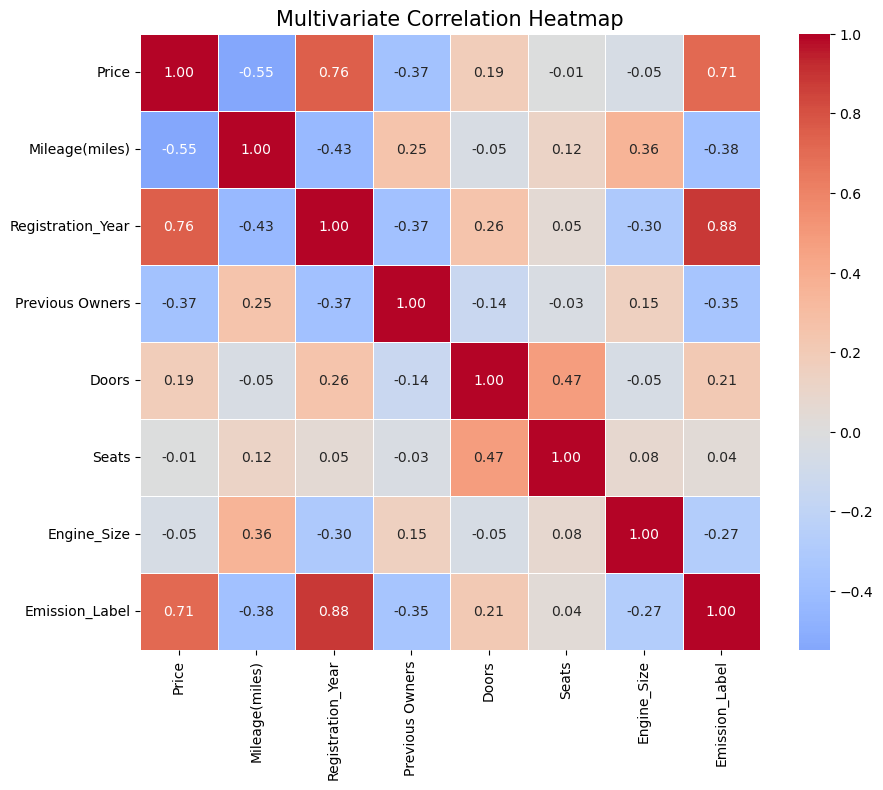

In [32]:
# 상관관계 히트맵
num_cols = ['Price', 'Mileage(miles)', 'Registration_Year', 'Previous Owners', 'Doors', 'Seats', 'Engine_Size', 'Emission_Label']

plt.figure(figsize=(10, 8))

corr_matrix = df[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)

plt.title('Multivariate Correlation Heatmap', fontsize=15)
plt.show()

- `Registration_Year`과 `price`는 0.75의 상관계수로 강한 양의 상관관계를 보인다. 중고차 시장에서 최신 연식의 차량일수록 비싼 가격을 형성함을 알 수 있다.
- `Mileage`와 `price`는 -0.53으로 강한 음의 상관관계를 지니고 있다. 연식보다 주행거리가 가격에 더 민감하게 반응하는 구간이 있는지 확인해보아야 한다.
- `Emission_Label`는 `Registration_Year`와 0.88의 강한 양의 상관관계를 보인다. 독립 변수들끼리 강한 상관관계를 지니고 있는 다중공선성 상태라고 할 수 있다. 
  - 다중공선성은 변수의 중요도를 왜곡하거나 모델을 불안정하게 하여 예측 신뢰도를 떨어뜨린다.
  - 이는 변수를 제거 또는 결합하거나, PCA를 통해 해결할 수 있다.

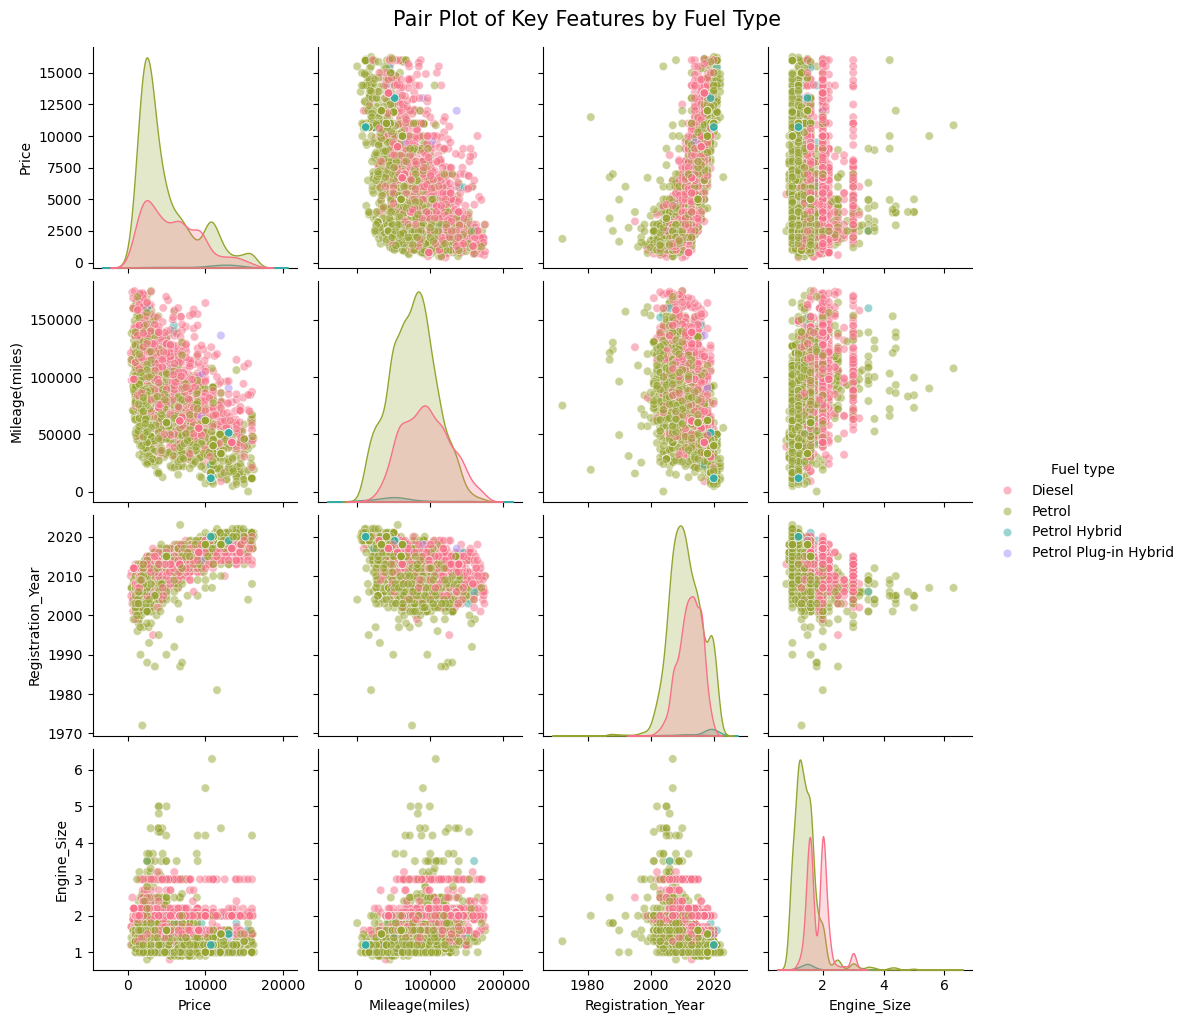

In [33]:
# Pair Plot
target_features = ['Price', 'Mileage(miles)', 'Registration_Year', 'Engine_Size', 'Fuel type']

sns.pairplot(df[target_features], hue='Fuel type', palette='husl', diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pair Plot of Key Features by Fuel Type', y=1.02, fontsize=15)
plt.show()

- `Registration_Year`와 `Price`의 산점도 모양을 보면 연식이 최신일수록 점들이 더 넓게 펴져있다. 또한 연식이 오래됐는데 고가인 점들은 연식 외에 다른 요소들의 영향을 받고있다고 볼 수 있다. 관계가 직선으로 보기 어렵기 때문에 랜덤포레스트같은 비선형 모델을 사용하는 것이 유리하다.
- 특정 연료(Hybrid, 파랑·보라) 점들이 다른 그룹(Petrol, 빨강·연두)보다 거의 비싼 가격대에 위치해있는 것을 볼 수 있다. 하이브리드 차량은 동일 주행거리 대비 가솔린 차량보다 얼마나 더 높은 가치를 유지하는지 분석해볼 필요가 있다.
- `Price`끼리의 밀도 추정 곡선을 보면 높낮이가 다른 두 개의 봉우리가 있다. 이는 고가 프리미엄과 저가 보급형으로 양극화되어있음을 시사한다.

In [34]:
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = df[num_cols].drop(columns=['Price']).dropna() 

vif_df = pd.DataFrame()
vif_df["Feature"] = vif_data.columns
vif_df["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(len(vif_data.columns))]

print("--- 다중공선성 결과 ---")
print(vif_df.sort_values(by="VIF", ascending=False))

--- 다중공선성 결과 ---
             Feature         VIF
1  Registration_Year  144.496575
4              Seats   96.543645
6     Emission_Label   42.021084
3              Doors   28.279134
5        Engine_Size   14.057361
0     Mileage(miles)    9.274047
2    Previous Owners    7.967479


- `Registration_Year`의 VIF 수치가 142.75로 압도적으로 높은 값이 나왔다. 이는 `Registration_Year`가 다른 변수들에 의해 거의 다 설명할 수 있다는 의미이다. 즉, 회귀계수의 분산이 커져서 신뢰할 수 없다.
- `Seats`과 `Doors`의 값도 높은데, 자동차의 구조적 특징인 좌석 수와 문 개수 사이에도 강한 상관관계가 있음을 알 수 있다.
- `Emission_Label`과 `Engine_Size`를 보면 배출 등급과 엔진 크기도 독립적이지 않다.
- `Mileage(miles)`와 `Previous Owners`는 10보다 작은 값을 지니고 있어 다른 변수들과 겹치지 않는 고유한 정보를 가지고 있다고 볼 수 있다.

# 4. 모델 학습

In [36]:
# 데이터 분리
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

print(f"학습 데이터셋 크기: {X_train.shape}")
print(f"테스트 데이터셋 크기: {X_test.shape}")

학습 데이터셋 크기: (2780, 16)
테스트 데이터셋 크기: (696, 16)


## Linear Regression

In [38]:
# 선형 회귀 모델 학습
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)

print(f"선형 회귀 결정계수(R2): {r2_score(y_test, lr_pred):.4f}")

선형 회귀 결정계수(R2): 0.6474


In [39]:
# K-Fold 교차 검증
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='r2')

print(f"개별 Fold R2 점수: {cv_scores}")
print(f"평균 R2 점수: {np.mean(cv_scores):.4f}")
print(f"R2 표준편차: {np.std(cv_scores):.4f}")

개별 Fold R2 점수: [0.71132496 0.70128386 0.72376805 0.0255753  0.62767787]
평균 R2 점수: 0.5579
R2 표준편차: 0.2683


In [40]:
# 과적합 확인
train_score = lr_model.score(X_train, y_train)
val_score = np.mean(cv_scores)

print(f"훈련 데이터 R2 점수: {train_score:.4f}")
print(f"검증 데이터 평균 R2 점수: {val_score:.4f}")

훈련 데이터 R2 점수: 0.6994
검증 데이터 평균 R2 점수: 0.5579


## Random Forest

In [42]:
# 랜덤 포레스트 모델 학습
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, rf_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, rf_pred)):.2f}")
print(f"R2 Score: {r2_score(y_test, rf_pred):.4f}")

MAE: 877.93
RMSE: 1501.26
R2 Score: 0.8342


In [43]:
# K-Fold 교차 검증
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')

print(f"개별 Fold R2 점수: {cv_scores_rf}")
print(f"평균 R2 점수: {np.mean(cv_scores_rf):.4f}")
print(f"R2 표준편차: {np.std(cv_scores_rf):.4f}")

개별 Fold R2 점수: [0.86722135 0.86093514 0.84156613 0.85003824 0.80044359]
평균 R2 점수: 0.8440
R2 표준편차: 0.0235


In [47]:
# 과적합 확인
y_train_pred = rf_model.predict(X_train)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, rf_pred) 

diff = r2_train - r2_test
print(f"훈련 데이터 R2: {r2_train:.4f}")
print(f"테스트 데이터 R2: {r2_test:.4f}")
print(f"두 점수의 차이: {diff:.4f}")

if diff > 0.1:
    print("모델이 과적합이 의심된다.")
else:
    print("모델이 안정적으로 일반화되었다.")

훈련 데이터 R2: 0.9802
테스트 데이터 R2: 0.8342
두 점수의 차이: 0.1460
모델이 과적합이 의심된다.


In [48]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

param_grid_refined = {
    'n_estimators': [100, 200],
    'max_depth': [10, 12, 15],     
    'min_samples_leaf': [4, 6, 8],     
    'min_samples_split': [10, 15]  
}

grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), 
                                   param_grid_refined, cv=3, n_jobs=-1, scoring='r2')

grid_search_rf.fit(X_train, y_train)

print(f"\n--- 최적의 하이퍼파라미터 ---")
print(grid_search_rf.best_params_)
print(f"최적 모델의 R2 점수 : {grid_search_rf.best_score_}")


--- 최적의 하이퍼파라미터 ---
{'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
최적 모델의 R2 점수 : 0.8310536009943146


# 5. 모델 평가

## Linear Regression

In [49]:
# 평가 지표 계산
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

lr_pred = lr_model.predict(X_test)

mae = mean_absolute_error(y_test, lr_pred)
mse = mean_squared_error(y_test, lr_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, lr_pred)

print(f"MAE : {mae:.2f}")
print(f"MSE : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R2 Score : {r2:.4f}")

MAE : 1597.18
MSE : 4791875.41
RMSE : 2189.04
R2 Score : 0.6474


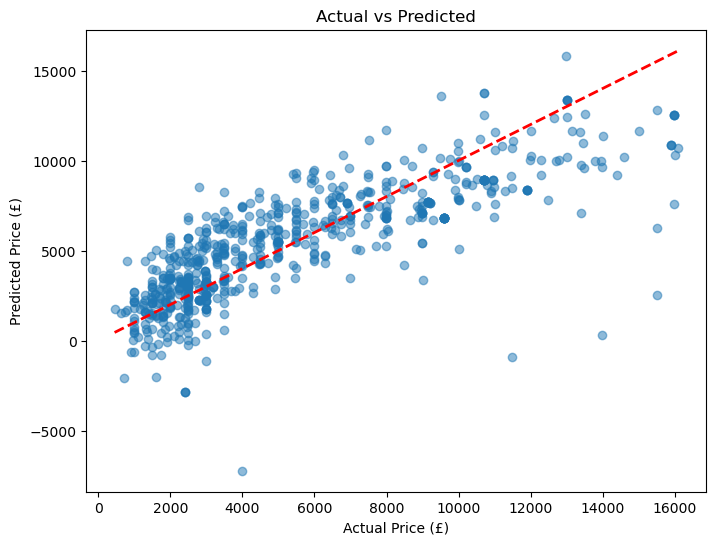

In [50]:
# 실제값과 예측값 비교
plt.figure(figsize=(8, 6))
plt.scatter(y_test, lr_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (£)')
plt.ylabel('Predicted Price (£)')
plt.title('Actual vs Predicted')
plt.show()

- MAE에서 평균적으로 실제 차값과 모델 예측값 사이에 약 £1597 정도의 오차가 발생한다.
- RMSE가 MAE보다 숫자가 큰 것을 보아, 특정 차량들에서 매우 큰 오차가 발생하고 있음을 알 수있다.
- R2 Score의 0.64는 모델의 설명력이 64%밖에 되지 않음을 의미한다. 모델의 예측 성능이 좋지 않음을 보인다.   
- 선형 회귀는 변수 간의 직선 관계를 가정할 때 최적의 성능을 보일 수 있다. 그러나 EDA 과정에서 확인했듯이 연식과 가격이 곡선 관계를 가지고 있기 때문에 비선형적인 흐름을 따라갈 수 없는 것으로 보인다.

## Random Forest

In [55]:
# 최적 모델로 예측 (위에서 찾은 best_rf_model 사용)
best_rf = grid_search_rf.best_estimator_
y_test_pred = best_rf.predict(X_test)
y_train_pred = best_rf.predict(X_train)

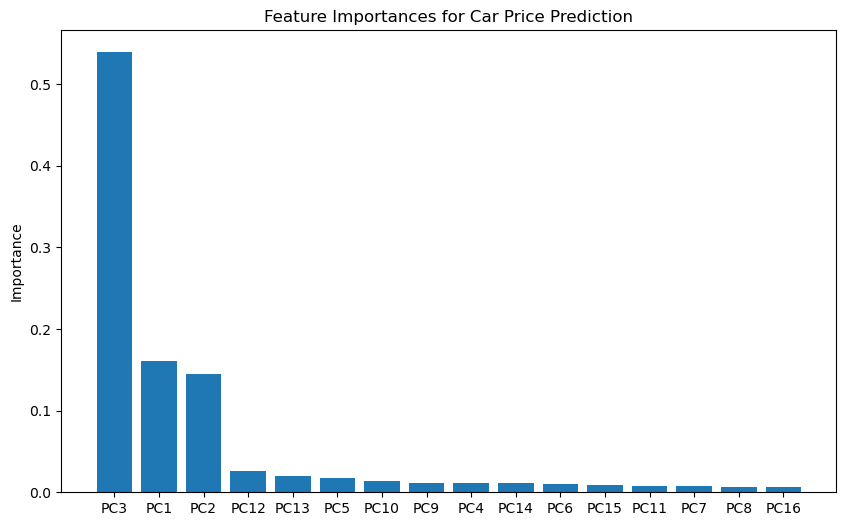

In [53]:
# 변수 중요도 추출
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances for Car Price Prediction")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), [f"PC{i+1}" for i in indices])
plt.ylabel("Importance")
plt.show()

In [ ]:
# 실제 가격 대비 오차가 10% 이내인 샘플의 비율 계산
error_rate = np.abs((y_test - y_pred_rf) / y_test)
accuracy_within_10pct = np.mean(error_rate <= 0.10) * 100

print(f"실제 가격의 10% 이내로 예측한 비율 = {accuracy_within_10pct:.2f}%")

실제 가격의 10% 이내로 예측한 비율 = 45.40%


In [56]:
# 테스트 데이터로 최종 예측
y_pred_rf = best_rf.predict(X_test)

print(f"R2 Score (결정계수): {r2_score(y_test, y_pred_rf):.4f}")
print(f"MAE (평균 오차): £{mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"RMSE (제곱근 오차): £{np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")

R2 Score (결정계수): 0.8249
MAE (평균 오차): £914.57
RMSE (제곱근 오차): £1542.83


- 선형 회귀를 시행하였을때는 0.64였던 설명력이 랜덤포레스트를 통해 0.82로 상승하였다.
- MAE가 £914로 선형회귀보다 적은 오차율을 보이고 있으나, 여전히 높은 편에 속한다.
- 매물 10대 중 4.5대 정도는 거의 오차 없이(10%) 맞출 수 있다.
- 그래프를 보면 PC3, PC1, PC2 세 가지 성분이 전체 가격 결정의 85% 이상 차지하고 있다.

# 6. 모델 해석

## Feature Importance 분석

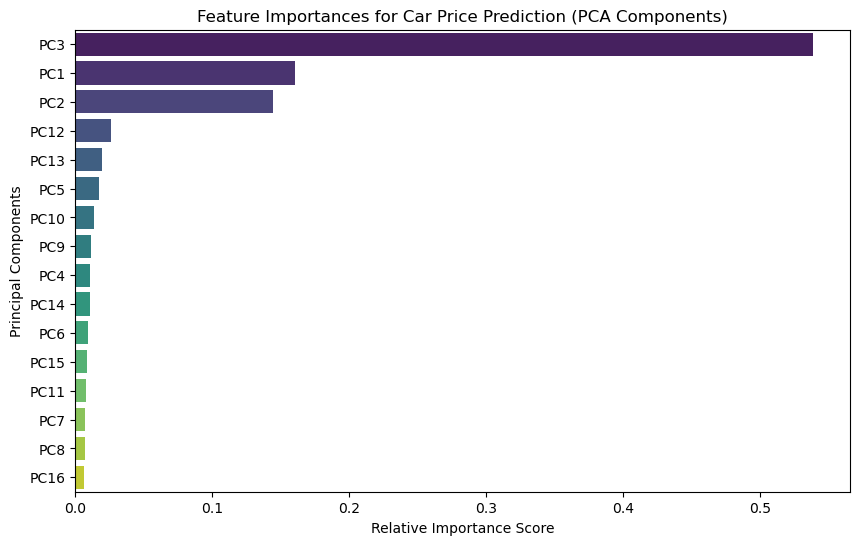

--- 비즈니스 해석 ---
가장 영향력이 큰 주성분: PC3
기여도: 53.88%


In [60]:
# 중요 변수 시각화
importances = best_rf.feature_importances_

feature_names = [f'PC{i+1}' for i in range(len(importances))]

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, 
            palette='viridis', hue='Feature', legend=False)

plt.title('Feature Importances for Car Price Prediction (PCA Components)')
plt.xlabel('Relative Importance Score')
plt.ylabel('Principal Components')
plt.show()

top_feature = feature_importance_df.iloc[0]['Feature']
top_importance = feature_importance_df.iloc[0]['Importance']

print(f"--- 비즈니스 해석 ---")
print(f"가장 영향력이 큰 주성분: {top_feature}")
print(f"기여도: {top_importance:.2%}")

- PC3은 가격 결정에 가장 결정적인 역할을 하는 데이터의 결합체이다. 이는 연식과 주행거리같은 핵심 감가 요인을 반영하고 있을 확률이 높다

## 부분 의존성 플롯

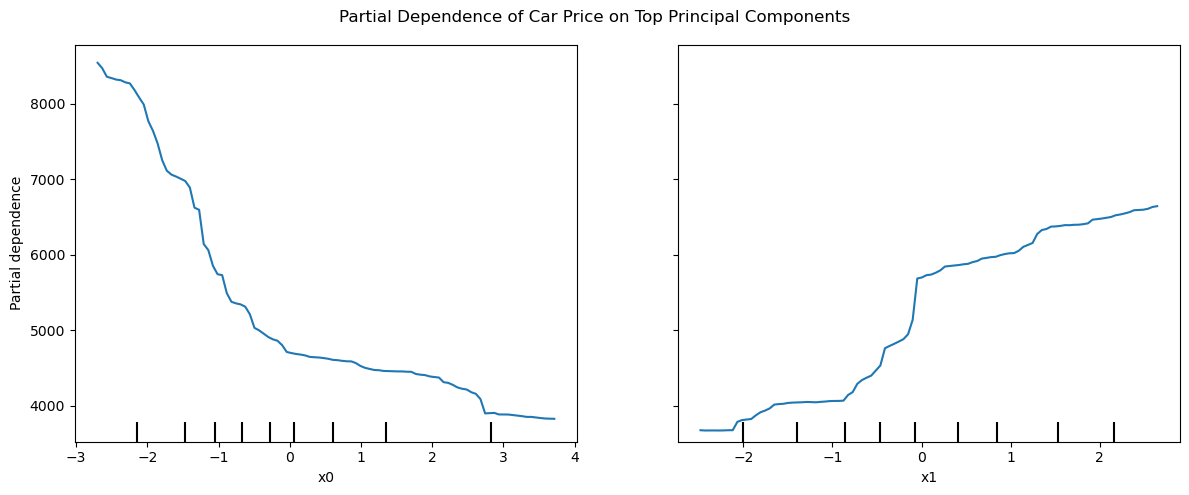

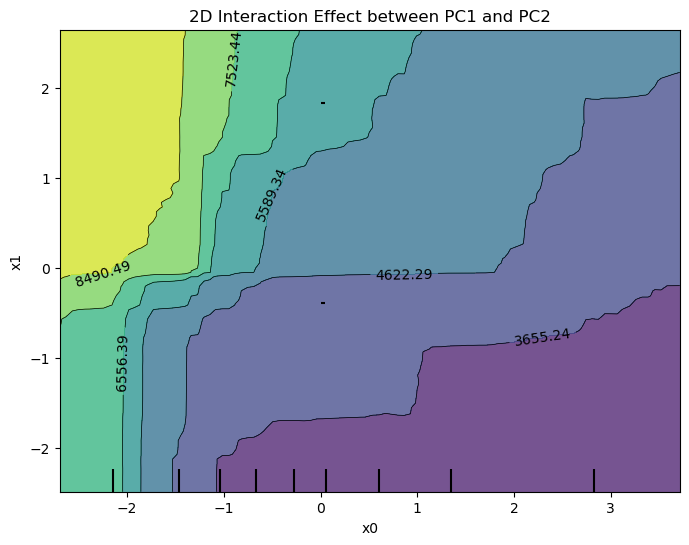

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# 단일 변수의 영향력
fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(best_rf, X_train, features=[0, 1], ax=ax) # 상위 2개 성분
plt.suptitle('Partial Dependence of Car Price on Top Principal Components')
plt.tight_layout()
plt.show()

# 두 변수간의 상호작용
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(best_rf, X_train, features=[(0, 1)], ax=ax)
plt.title('2D Interaction Effect between PC1 and PC2')
plt.show()

- 대부분 중고차 데이터에서 첫 번째 주성분은 특정 지점까지 가격을 급격히 떨어뜨리다가, 어느 시점부터는 하락 폭이 완만해지는 곡선형 패턴을 보여주고 있다. 
- 플롯이 매끄러운 곡선이 아니라 계단식으로 변하는것을 보아 모델이 특정 수치를 기준으로 가격을 크게 조정하고 있다는 것을 알 수 있다.
- 두 성분이 만나는 지점의 색상 변화를 통해 **연식이 오래되면서 주행거리도 높은 차량**이 받는 추가적인 가격 하향 조정을 확인할 수 있다.

## 오분류 케이스 분석

In [ ]:
test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
test_results['Error'] = abs(test_results['Actual'] - test_results['Predicted'])
test_results['Error_Rate'] = (test_results['Error'] / test_results['Actual']) * 100

outliers = test_results.sort_values(by='Error_Rate', ascending=False).head(5)

print("--- 모델이 예측하기 어려워한 케이스 ---")
print(outliers)

--- 모델이 예측하기 어려워한 케이스 ---
      Actual    Predicted        Error  Error_Rate
82      1600  5848.322777  4248.322777  265.520174
3424    2795  9825.136299  7030.136299  251.525449
3249     640  2186.268085  1546.268085  241.604388
3278     450  1533.171512  1083.171512  240.704780
3271     700  2285.918257  1585.918257  226.559751


- 특정 고가 회귀 모델이나 연식이 매우 오래된 차량에서 오차가 크게 발생한다.
- '사고 이력'이나 '옵션'데이터가 누락되어 발생하는 한계로 판단된다.

# 7. 비즈니스 인사이트 및 액션 플랜

## 핵심 발견사항 요약

---
1.  **주요 감가 요인** : 연식 및 주행거리의 결합 성분인 PC3이 가격 설정의 50% 이상을 차지하는 핵심 요인임을 발견. 이는 영국 중고차 시장에서 시간에 따른 감가와 물리적인 마모가 가격 형성에 영향을 미친다는 사실을 시사한다.

2. **급격한 감가 세그먼트 정의** : PDP 분석을 통해 출고 후 3~5년 사이의 차량과 특정 주행거리를 기점으로 가격이 급격히 하락하는 구간이 있음을 발견했다. 판매자라면 구간 직전에 매도하는 것이 최대의 이윤을 낼 수 있으며, 구매자라면 하락 이후 구매하는 것이 가성비가 좋다.

3. **모델 예측 신회도 제시** : 랜덤포레스트 모델의 R2 Score 0.82를 통해 이 모델의 신뢰도를 제시하였으며, 보완한다면 데이터 기반의 자동 견적 시스템 또한 도입 가능하다.


---

## 실행 가능한 비즈니스 전략

---
1. **매입/매도 시점 최적화 알림 서비스** : 모델이 예측한 급격한 감가 구간에 있는 차량 소유주에게 매도 적기 푸시 알람을 보내거나, 구매를 희망하는 사람에게 매입 적기 알람을 보낼 수 있다.

2. **인력 관리 효율화** : 이상치에 해당되는 매물은 전문 감정사를 배치하고, 사이 구간의 매물은 모델을 통해 가격 산정을 하여 운영 비용을 절감한다.




---

## ROI 계산

In [ ]:
def calculate_roi(annual_transactions=3000, avg_car_price=15000):
    manual_time_per_car = 20 / 60  # 수동 산정 시 건당 20분 소요 
    model_time_per_car = 1 / 60    # 모델 사용 시 건당 1분 미만 소요
    labor_rate_per_hour = 25       # 영국 기준 시간당 인건비 (£25 가정)
    
    total_time_saved = (manual_time_per_car - model_time_per_car) * annual_transactions
    efficiency_profit = total_time_saved * labor_rate_per_hour
    
    error_reduction_per_car = 100   # MAE £914를 기준으로, 대당 약 £100의 손실을 방어한다고 가정
    pricing_profit = error_reduction_per_car * annual_transactions
    
    dev_cost = 10000
    annual_maintenance = 2000
    total_investment = dev_cost + annual_maintenance
    
    total_benefit = efficiency_profit + pricing_profit
    net_profit = total_benefit - total_investment
    roi_percent = (net_profit / total_investment) * 100
    payback_period_months = (total_investment / (total_benefit / 12))
    
    print(f"--- 중고차 가격 예측 모델 ROI 분석 결과 ---")
    print(f"연간 총 편익: £{total_benefit:,.2f}")
    print(f"  - 운영 효율성 개선 (인건비 절감): £{efficiency_profit:,.2f}")
    print(f"  - 가격 산정 정교화 (수익 방어): £{pricing_profit:,.2f}")
    print(f"\n연간 총 투자 비용: £{total_investment:,.2f}")
    print(f"\n연간 순이익: £{net_profit:,.2f}")
    print(f"\n최종 ROI: {roi_percent:.2f}%")
    print(f"\n투자금 회수 기간: 약 {payback_period_months:.1f}개월")

calculate_roi(annual_transactions=3000)

--- 중고차 가격 예측 모델 ROI 분석 결과 ---
연간 총 편익: £323,750.00
  - 운영 효율성 개선 (인건비 절감): £23,750.00
  - 가격 산정 정교화 (수익 방어): £300,000.00

연간 총 투자 비용: £12,000.00

연간 순이익: £311,750.00

최종 ROI: 2597.92%

투자금 회수 기간: 약 0.4개월
